In [1]:
import torch, tqdm
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# GPU

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

# Transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),]
)

GPU State: cuda:0


In [2]:
# Data
valid_size=0.2
shuffle = True
random_seed = 100
trainSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
valSet = datasets.MNIST(root='MNIST', download=True, train=True, transform=transform)
testSet = datasets.MNIST(root='MNIST', download=True, train=False, transform=transform)

num_train = len(trainSet)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
batch_size = 64
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(valSet, batch_size=batch_size, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batch_size, shuffle=False)

In [3]:
# Model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class deep_Net(torch.nn.Module):
    def __init__(self):
        super(deep_Net, self).__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.25),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=9216, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(in_features=128, out_features=10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        return self.main(input)    



net_1 = Net().to(device)
net_2 = deep_Net().to(device)
print(net_1)
print(net_2)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
deep_Net(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten()
    (7): Linear(in_features=9216, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
    (11): LogSoftmax(dim=1)
  )
)


In [4]:
def Accuracy(TRUTH, PREDICTION, BATCH_SIZE):
    return (TRUTH==PREDICTION).sum().item()/BATCH_SIZE

def train_fn(epochs, lr, optimizer_name, net, name_of_net):
    criterion = torch.nn.CrossEntropyLoss()
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
    else : 
        print("Error, please input 'SGD' or Adam.")
    # Train
    epoch_loss = []
    epoch_acc = []
    epoch_val_loss = []
    epoch_val_acc = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_acc = 0.0
        running_loss_val = 0.0
        running_acc_val = 0.0
        
        for times, data in enumerate(trainLoader):
            net.train()
#             print("Training")
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Foward + backward + optimize
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
#             print(predicted, outputs.data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            running_acc += Accuracy(labels, predicted, trainLoader.batch_size)
#             if times % 100 == 99 or times+1 == len(trainLoader):
#                 print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(trainLoader), running_loss/trainLoader.batch_size))
        with torch.no_grad():
            net.eval()
#             print("Validating.")
            for times_val, data_val in enumerate(valLoader):
                inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
        #         inputs = inputs.view(inputs.shape[0], -1)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Foward + backward + optimize
                outputs_val = net(inputs_val)
                _, predicted_val = torch.max(outputs_val.data, 1)
                loss_val = criterion(outputs_val, labels_val)
#                     loss_val.backward()
#                     optimizer.step()

                # Print statistics
                running_loss_val += loss_val.item()
                running_acc_val += Accuracy(labels_val, predicted_val, trainLoader.batch_size)
            _epoch_val_loss = running_loss_val/len(valLoader)
            _epoch_val_acc = running_acc_val/len(valLoader)
            epoch_val_loss.append(_epoch_val_loss)
            epoch_val_acc.append(_epoch_val_acc)
                
        _epoch_loss = running_loss/len(trainLoader)
        _epoch_acc = running_acc/len(trainLoader)
        epoch_loss.append(_epoch_loss)
        epoch_acc.append(_epoch_acc)
        print("Epoch: {0}, loss: {1:.3f}, acc: {2:.3f}, val_loss: {3:.3f}, val_acc: {4:.3f}".format(epoch+1, _epoch_loss, _epoch_acc, _epoch_val_loss, _epoch_val_acc))
    print('Training Finished.')
    
    correct = 0
    total = 0

    with torch.no_grad():
        net.eval()
        for data in testLoader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct / total) )

    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]

    with torch.no_grad():
        net.eval()
        for data in testLoader:
            inputs, labels = data[0].to(device), data[1].to(device)
    #         inputs = inputs.view(inputs.shape[0], -1)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    #             print(class_correct)
    #             print(class_total)

    for i in range(10):
        print('Accuracy of %d: %3f' % (i, (class_correct[i]/class_total[i])))
    acc = (100*correct/total)
    x = np.linspace(1, epochs, num = epochs)
    plt.plot(x, epoch_acc, label='acc')
    plt.plot(x, epoch_loss, label='loss')
    plt.plot(x, epoch_val_loss, label='val_loss')
    plt.plot(x, epoch_val_acc, label='epoch_acc')
    plt.xlabel('epochs')
    plt.ylabel('acc/loss')
    plt.legend(loc="upper right")
    plt.savefig("mnist_cnn_"+optimizer_name+str(name_of_net)+"_ce_deep_"+str(int(acc))+".png")
    plt.show()

Epoch: 1, loss: 0.212, acc: 0.935, val_loss: 0.058, val_acc: 0.981
Epoch: 2, loss: 0.092, acc: 0.974, val_loss: 0.049, val_acc: 0.983
Epoch: 3, loss: 0.071, acc: 0.978, val_loss: 0.040, val_acc: 0.986
Epoch: 4, loss: 0.060, acc: 0.981, val_loss: 0.042, val_acc: 0.985
Epoch: 5, loss: 0.051, acc: 0.985, val_loss: 0.044, val_acc: 0.984
Epoch: 6, loss: 0.046, acc: 0.987, val_loss: 0.034, val_acc: 0.988
Epoch: 7, loss: 0.041, acc: 0.987, val_loss: 0.034, val_acc: 0.987
Epoch: 8, loss: 0.040, acc: 0.988, val_loss: 0.034, val_acc: 0.988
Epoch: 9, loss: 0.036, acc: 0.989, val_loss: 0.039, val_acc: 0.987
Epoch: 10, loss: 0.032, acc: 0.990, val_loss: 0.040, val_acc: 0.987
Training Finished.
Accuracy of the network on the 10000 test images: 99 %
Accuracy of 0: 0.993421
Accuracy of 1: 0.989189
Accuracy of 2: 0.988372
Accuracy of 3: 0.987179
Accuracy of 4: 0.983051
Accuracy of 5: 0.992063
Accuracy of 6: 0.976562
Accuracy of 7: 0.993902
Accuracy of 8: 0.993007
Accuracy of 9: 0.994012


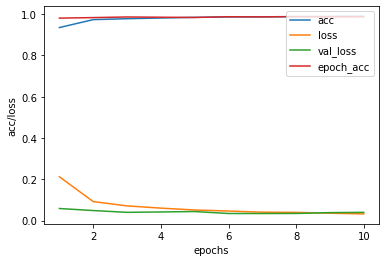

In [5]:
train_fn(10, 0.01, "Adam", net_1, "_with_maxpooling_dropout")

Epoch: 1, loss: 0.212, acc: 0.935, val_loss: 0.063, val_acc: 0.978
Epoch: 2, loss: 0.092, acc: 0.973, val_loss: 0.049, val_acc: 0.983
Epoch: 3, loss: 0.070, acc: 0.979, val_loss: 0.053, val_acc: 0.983
Epoch: 4, loss: 0.062, acc: 0.981, val_loss: 0.048, val_acc: 0.985
Epoch: 5, loss: 0.053, acc: 0.984, val_loss: 0.041, val_acc: 0.985
Epoch: 6, loss: 0.045, acc: 0.986, val_loss: 0.042, val_acc: 0.986
Epoch: 7, loss: 0.044, acc: 0.986, val_loss: 0.041, val_acc: 0.986
Epoch: 8, loss: 0.038, acc: 0.988, val_loss: 0.036, val_acc: 0.988
Epoch: 9, loss: 0.035, acc: 0.989, val_loss: 0.042, val_acc: 0.986
Epoch: 10, loss: 0.033, acc: 0.990, val_loss: 0.039, val_acc: 0.988
Training Finished.
Accuracy of the network on the 10000 test images: 99 %
Accuracy of 0: 0.986842
Accuracy of 1: 0.994595
Accuracy of 2: 1.000000
Accuracy of 3: 0.987179
Accuracy of 4: 0.988701
Accuracy of 5: 0.984127
Accuracy of 6: 0.976562
Accuracy of 7: 0.993902
Accuracy of 8: 0.993007
Accuracy of 9: 0.994012


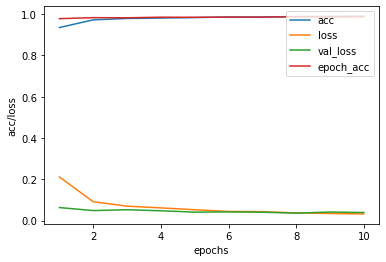

In [5]:
# net_1.apply(weights_init)
train_fn(10, 0.01, "Adam", net_2, "_with_maxpooling_dropout_method_2")